In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# Preprocess Caption

In [17]:
captions = {}
with open(r"C:\Users\Bhawna\Downloads\archive (1)\captions.txt", 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        img_id = parts[0]
        caption = ' '.join(parts[1:])
        img_id = img_id.split('#')[0]
        if img_id not in captions:
            captions[img_id] = []

        captions[img_id].append(caption)

In [19]:
all_captions = []
for key in captions.keys():
    for cap in captions[key]:
        all_captions.append('<start>' + cap + '<end>')

In [21]:
tokenizer = Tokenizer(num_words=5000, oov_token='<unk>')
tokenizer.fit_on_texts(all_captions)
max_length = max(len(c.split()) for c in all_captions)

In [50]:
caption_sequences = []
next_words = []

for cap in all_captions:
    seq = tokenizer.texts_to_sequences([cap])[0]
    for i in range(1, len(seq)):
        in_seq, out_word = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        caption_sequences.append(in_seq)
        next_words.append(out_word)

caption_sequences = np.array(caption_sequences)
next_words = to_categorical(next_words, num_classes=5000)

print("Images shape:", all_images.shape)
print("Caption sequences shape:", caption_sequences.shape)
print("Next words shape:", next_words.shape)


Images shape: (8091, 64, 64, 3)
Caption sequences shape: (437606, 37)
Next words shape: (437606, 5000)


# Preprocess Image

In [22]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [23]:
folder_path = r"C:\Users\Bhawna\Downloads\archive (1)\Images"
image_files = os.listdir(folder_path)
all_images = []
for file in image_files:
    img_path = os.path.join(folder_path, file)
    processed_img = preprocess_image(img_path)
    all_images.append(processed_img)
all_images = np.vstack(all_images)

# Build Model

In [32]:
image_input = Input(shape=(64,64,3))
x = layers.Conv2D(32, (3,3), activation='relu')(image_input)
x  = layers.MaxPooling2D((2,2))(x)
x  =  layers.Conv2D(64, (3,3), activation='relu')(x)
x  =  layers.MaxPooling2D((2,2))(x)
x  =  layers.Flatten()(x)
img_dense  = layers.Dense(256, activation='relu')(x)

In [33]:
caption_input = Input(shape=(max_length,))
y = layers.Embedding(input_dim=5000, output_dim=256, mask_zero=True)(caption_input)
y = layers.LSTM(256)(y)

In [34]:
merged_model = layers.add([img_dense, y])
merged_model = layers.Dense(256, activation='relu')(merged_model)
output = layers.Dense(5000, activation='softmax')(merged_model)

In [36]:
final_model = models.Model(inputs=[image_input, caption_input], outputs=output)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = final_model.fit([all_images, caption_sequences], next_words, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.0872 - loss: 6.3009 - val_accuracy: 0.1309 - val_loss: 5.5777
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.1575 - loss: 4.7907 - val_accuracy: 0.1643 - val_loss: 5.5056
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.1952 - loss: 4.3710 - val_accuracy: 0.1865 - val_loss: 5.4726
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.2266 - loss: 3.9654 - val_accuracy: 0.2026 - val_loss: 5.2545
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.2635 - loss: 3.6680 - val_accuracy: 0.1995 - val_loss: 5.4523


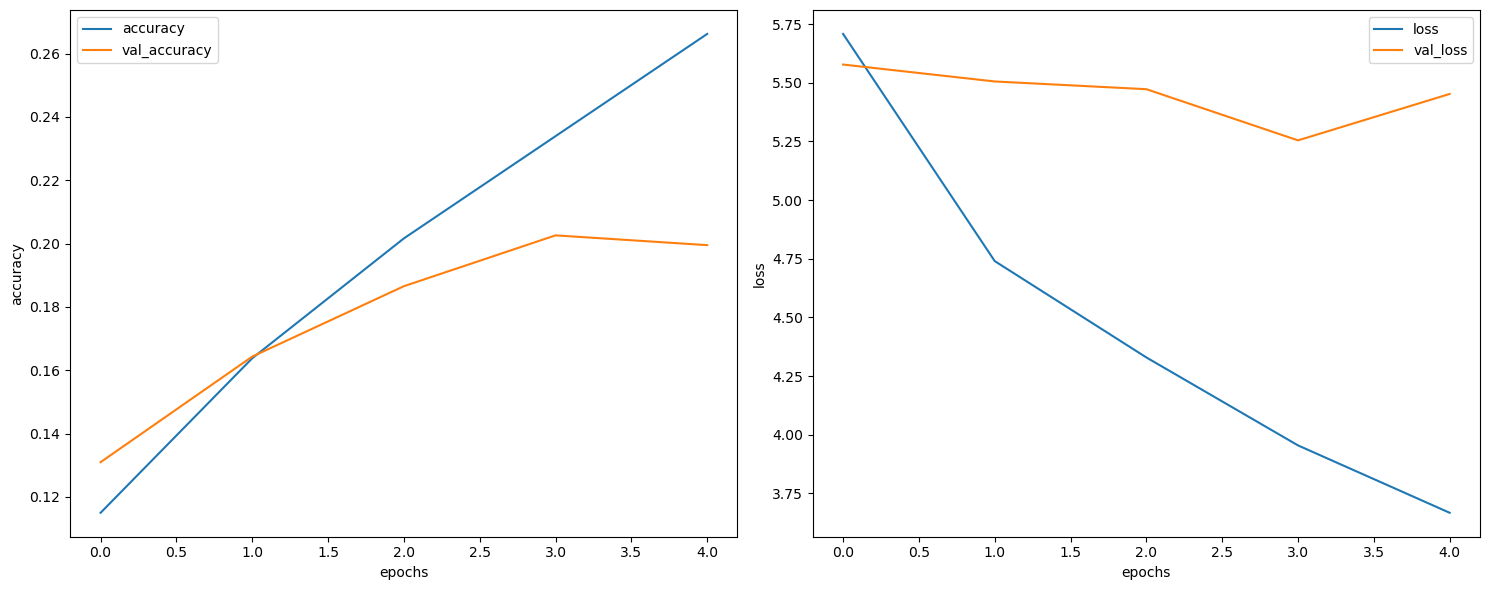

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].plot(history.history['accuracy'], label='accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].legend()
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')

axes[1].plot(history.history['loss'], label='loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].legend()
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')

plt.tight_layout()
plt.show()